In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%cd utils
import kmers
from kmers import kMerDF
from scipy.stats import zscore

X = pd.read_csv('../examples/XLTestingData.csv')['b3']
y = pd.read_csv('../examples/XLTestingData.csv')['label']



/Users/aidenh20/Polylong/utils


In [3]:
#Load attention scores, convert to numpy array
expl_scores = pd.read_csv('../examples/512ds/512expl.csv')['scores']
expl_scores = [str(i).split(' ') for i in expl_scores]
expl_scores = np.array(expl_scores).astype(float)

validation_labels = np.array(pd.read_csv('../examples/512ds/512expl.csv')['label'])

#load DNA sequences and their labels, convert to numpy arrays.
dnadf = pd.read_csv('../examples/XLTestingData.csv')['b3']
dnadf = np.array([str(i).split(' ') for i in dnadf])
labels = pd.read_csv('../examples/XLTestingData.csv')['label'].to_numpy()

#make sure all the sequences in both dataframes are sorted in the same order
assert validation_labels.all() == labels.all()

#create the kMerDF object
X = kMerDF(expl_scores, dnadf, labels)

#get the kMer object at row 0, column 506
print('kMerDF[0][506]: ' + str(X[0][506].score) + ' ' + str(X[0][506].seq) + ' ' + str(X[0][506].label))
temp = zscore(expl_scores)
print('zscore[0][506]: ' + str(temp[0][506]))

#showing this is the same kmer as the first in the dnadf
print('dnadf[0][506]: ' + dnadf[0][506])

kMerDF[0][506]: 1.516 CAGGCG 0
zscore[0][506]: 1.515550048484558
dnadf[0][506]: CAGGCG


In [4]:
def get_kmers_matching_region(kmer, kmerdf, start, end):
    """Returns a list of kMers that match the region of the kMer passed in.
    """
    matching_kmers = []
    i = 0
    while i < len(kmerdf): 
        j = start
        while j <= end:
            if kmerdf[i][j].seq == kmer:
                matching_kmers.append(kmerdf[i][j])
            j += 1
        i += 1
    return matching_kmers

positive_kmer_list = ["AGGTAG", "AGGTAA", "AGGTCA", "AAGAAA", "CACTTC", "TGCTGC", "CGCCGC", "CCAAGG", "CCATGT", "GGTAGG", "GGTGGG", "GGCGGC", "GGCGGG", "GGTGCG", "GGGGAG", "AGTGAG", "CGTGAG", "GGCGAG", "GGTGAG", "GGTAAG", "GGTCAG", "GCAGGA", "GCGGGC", "GTAGGT", "GTAGGG", "GTAAGA", "GTAGGA", "GTGGGC", "GTAGGC", "GTGGGT", "GTAAGC", "GTAAGG", "GTAAGT", "GTGAGT", "GTGAGG", "GTGAGC", "GTGAGA", "GTGAAG", "GTGGAG", "ATGGAG", "GAGGTG", "GAGGCG", "ATGGCG", "GTGGCG", "GCGGCG", "GCTGCT", "TGGCGG", "AGGTGA", "TGGTGA", "GGGTGA"]
negative_kmer_list = ["CACTTC", "AACAGA", "AACAGC", "AAATGA", "AAATGC", "AAATAA", "AATGAC", "TGTCAT", "AGTTCA", "TGTACA", "GGTGAG", "AGTCAC", "AGTGAC", "TGTGAC", "TGTGAA", "TGTAAA", "AGTAAA", "CAGTTA", "GTTTGA", "GTGTTT", "GTGTCA", "GAGTCA", "GACTCA", "GTCATA", "GTGATT", "GTGAAA", "TTGAAA", "GAGATA", "GTGACT", "GTGACA", "GTGTGA", "GTGAGT", "GTGAGC", "GTGAGA", "ATGAGA", "ATGAGC", "TTCTCA", "TTTCTA", "TTCTTA", "TTTTTA", "TTTTAA", "GTTTTA", "GTTTTC", "TGACTC", "ACATTT", "TCACTT", "GCACTT", "TGTTAC", "TGTTCT", "TGTTCA", "TGTGTA", "GGTTTC", "AGTTTT", "TGTTTA", "TGTTTT", "TGTTTC", "TGTTTG"]

def get_importance_of_kmer_at_position(kmer, kmerdf, pos, label):
    """Returns the sum of the importance scores for that kMer over all rows in the dataframe at the given position.
    """
    importance = 0
    for row_idx in range(0, len(kmerdf)):
        if kmerdf[row_idx][pos].seq == kmer and kmerdf[row_idx][pos].label == label:
            importance += kmerdf[row_idx][pos].score
    return importance

def get_importance_of_kmers_from_list(kmer_list, kmerdf, label):
    """Returns a dictionary of kMers and their importance in the given region.
    """
    r_df = pd.DataFrame(columns=[x for x in range(0, 506)])
    for i in range(0, 506):
        for kmer in kmer_list:
            importance = get_importance_of_kmer_at_position(kmer, kmerdf, i, label)
            r_df.loc[kmer, i] = importance
    return r_df


def counts_matching_regions_from_list(kmer_list, kmerdf):
    """Returns a dictionary of kMers and their counts in the given region.
    """
    r_df = pd.DataFrame(columns=[x for x in range(0, 506)])
    for i in range(0, 506):
        for kmer in kmer_list:
            count = len(get_kmers_matching_region(kmer, kmerdf, i, i))
            r_df.loc[kmer, i] = count
    return r_df


pos_kmer_counts = counts_matching_regions_from_list(positive_kmer_list, X)
pos_kmer_importance = get_importance_of_kmers_from_list(positive_kmer_list, X, 1)

In [5]:
pos_kmer_counts.to_csv('pos_kmer_counts.csv')
pos_kmer_importance.to_csv('pos_kmer_importance.csv')

In [7]:
pos_counts = pd.read_csv('pos_kmer_counts.csv').drop('labels', axis=1)
pos_importance = pd.read_csv('pos_kmer_importance.csv').drop('labels', axis=1)

<AxesSubplot:>

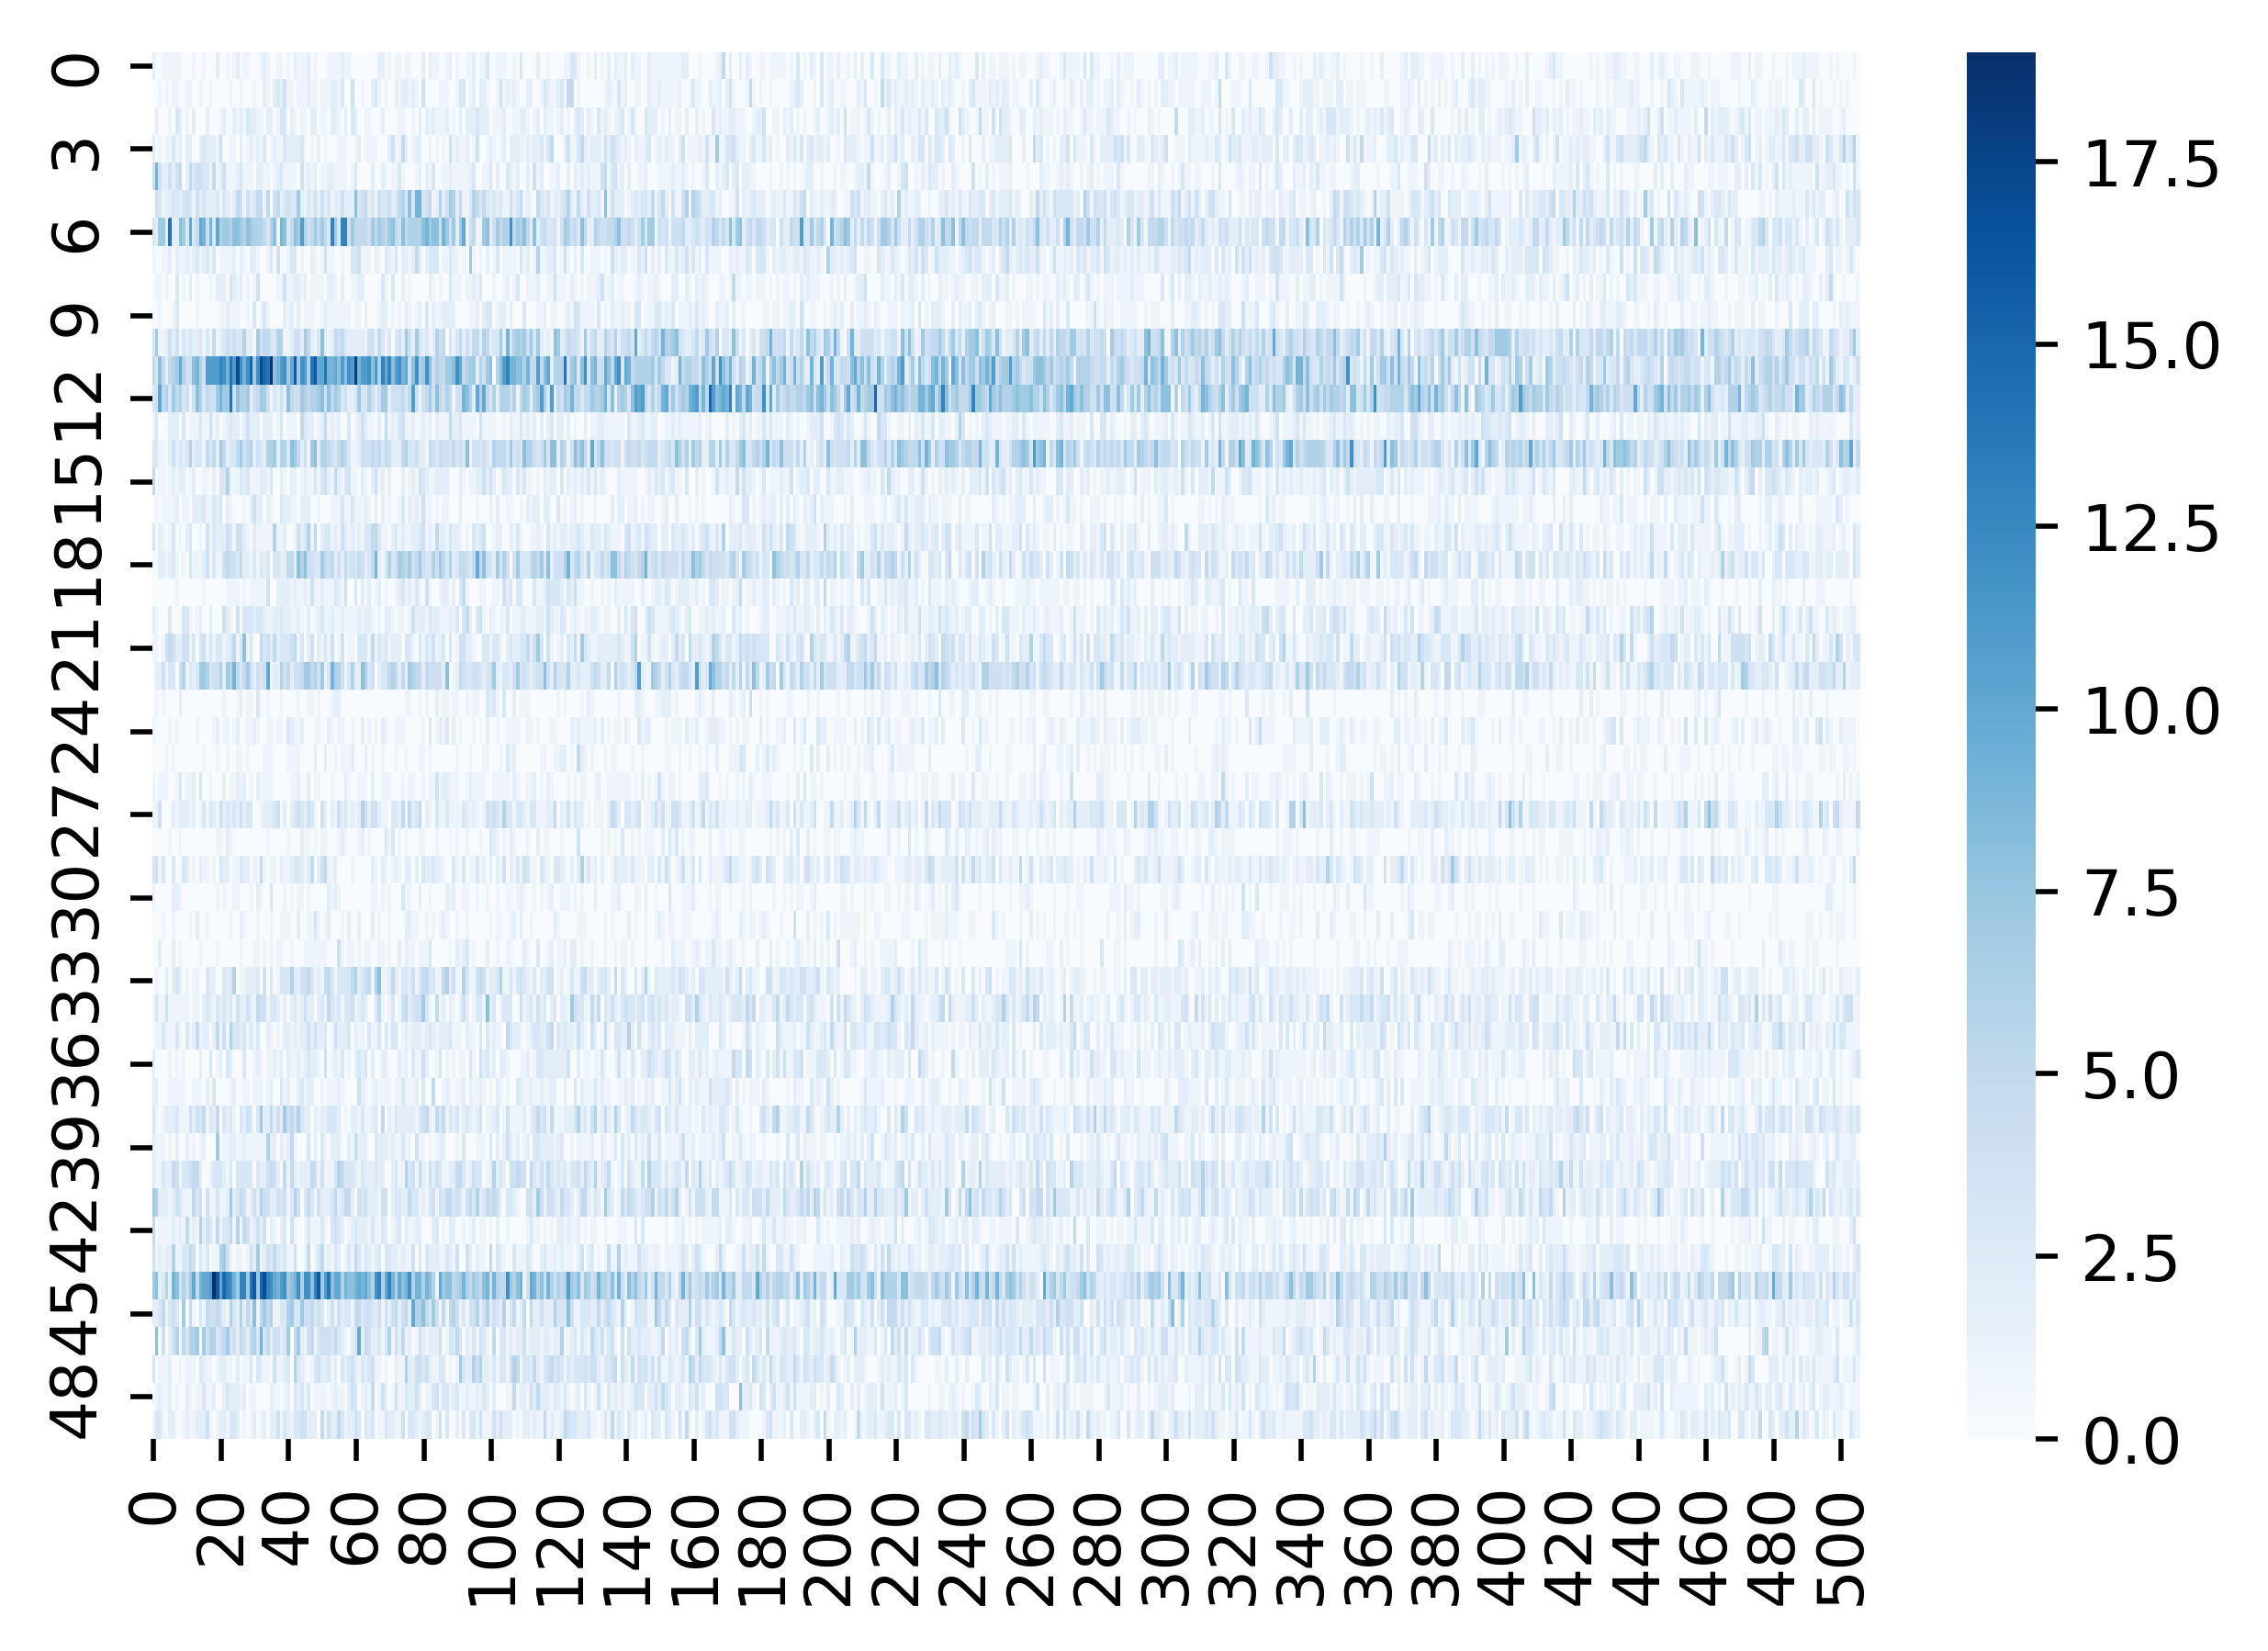

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

sns.heatmap(pos_counts, cmap='Blues')

<AxesSubplot:>

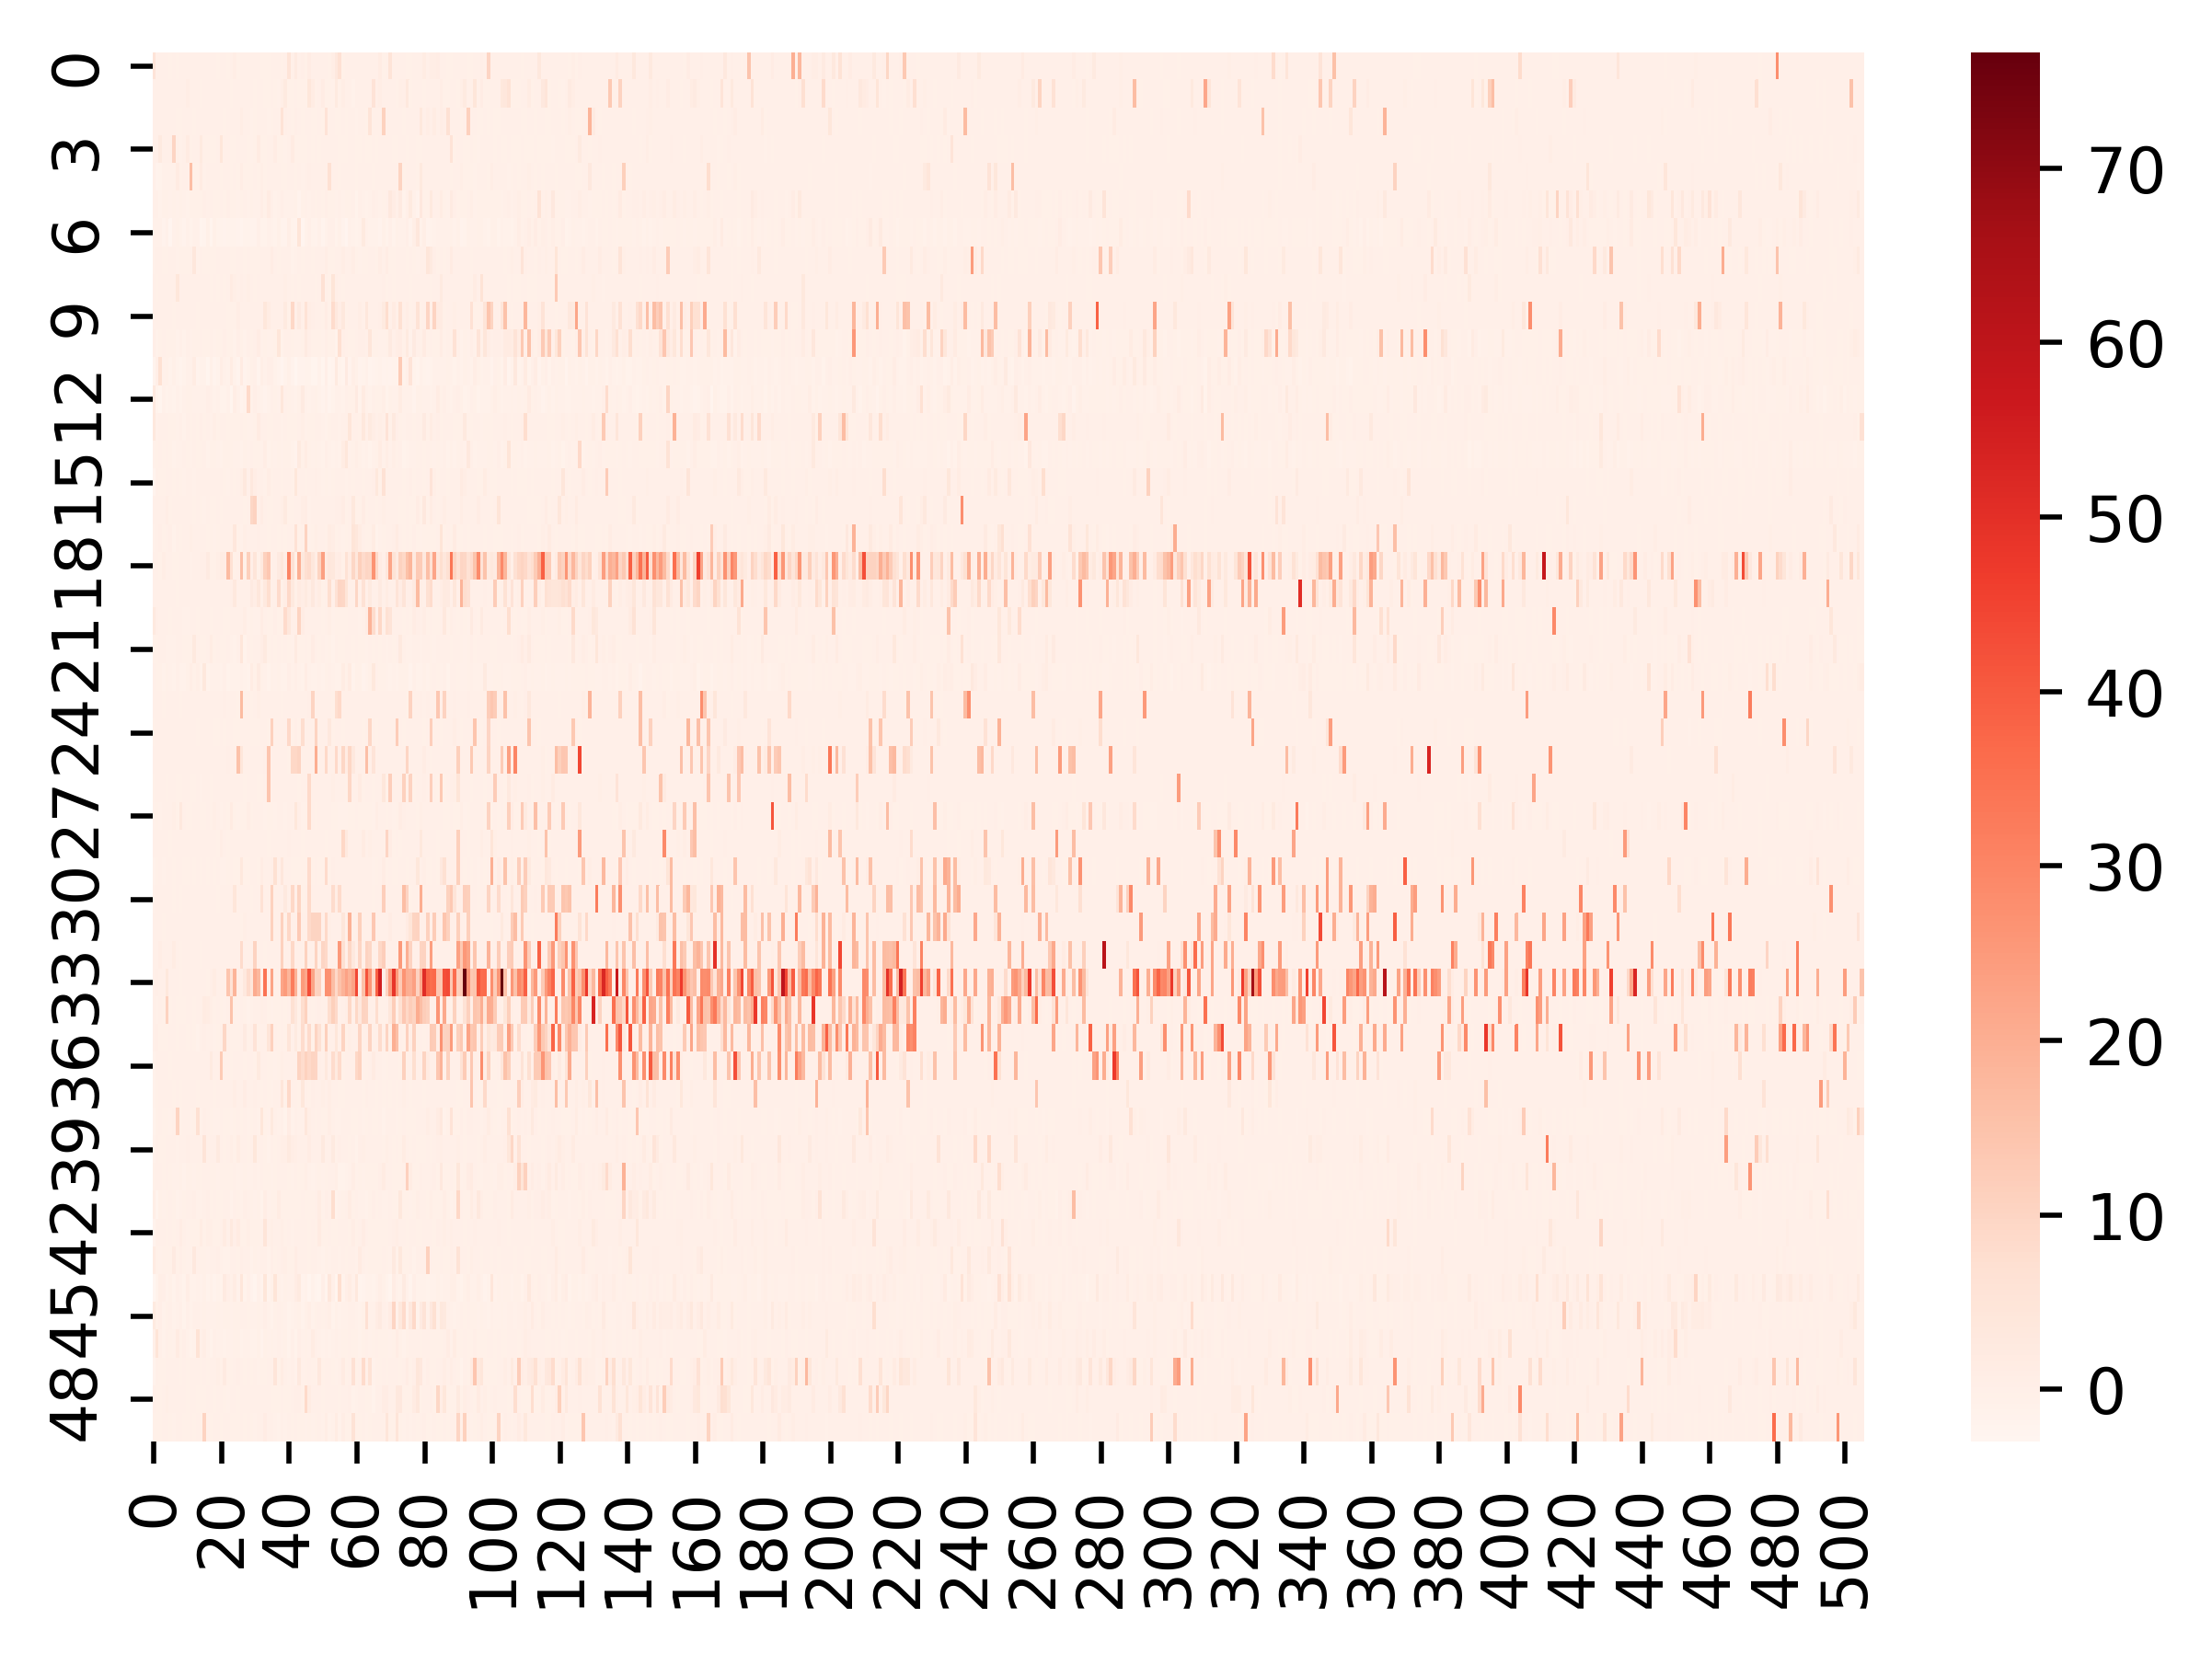

In [10]:
sns.heatmap(pos_importance, cmap='Reds')

In [15]:
neg_kmer_counts = counts_matching_regions_from_list(negative_kmer_list, X)
neg_kmer_importance = get_importance_of_kmers_from_list(negative_kmer_list, X, 0)

neg_kmer_counts.to_csv('neg_kmer_counts.csv')
neg_kmer_importance.to_csv('neg_kmer_importance.csv')

neg_counts = pd.read_csv('neg_kmer_counts.csv').drop('labels', axis=1)
neg_importance = pd.read_csv('neg_kmer_importance.csv').drop('labels', axis=1)

KeyError: "['labels'] not found in axis"

<AxesSubplot:>

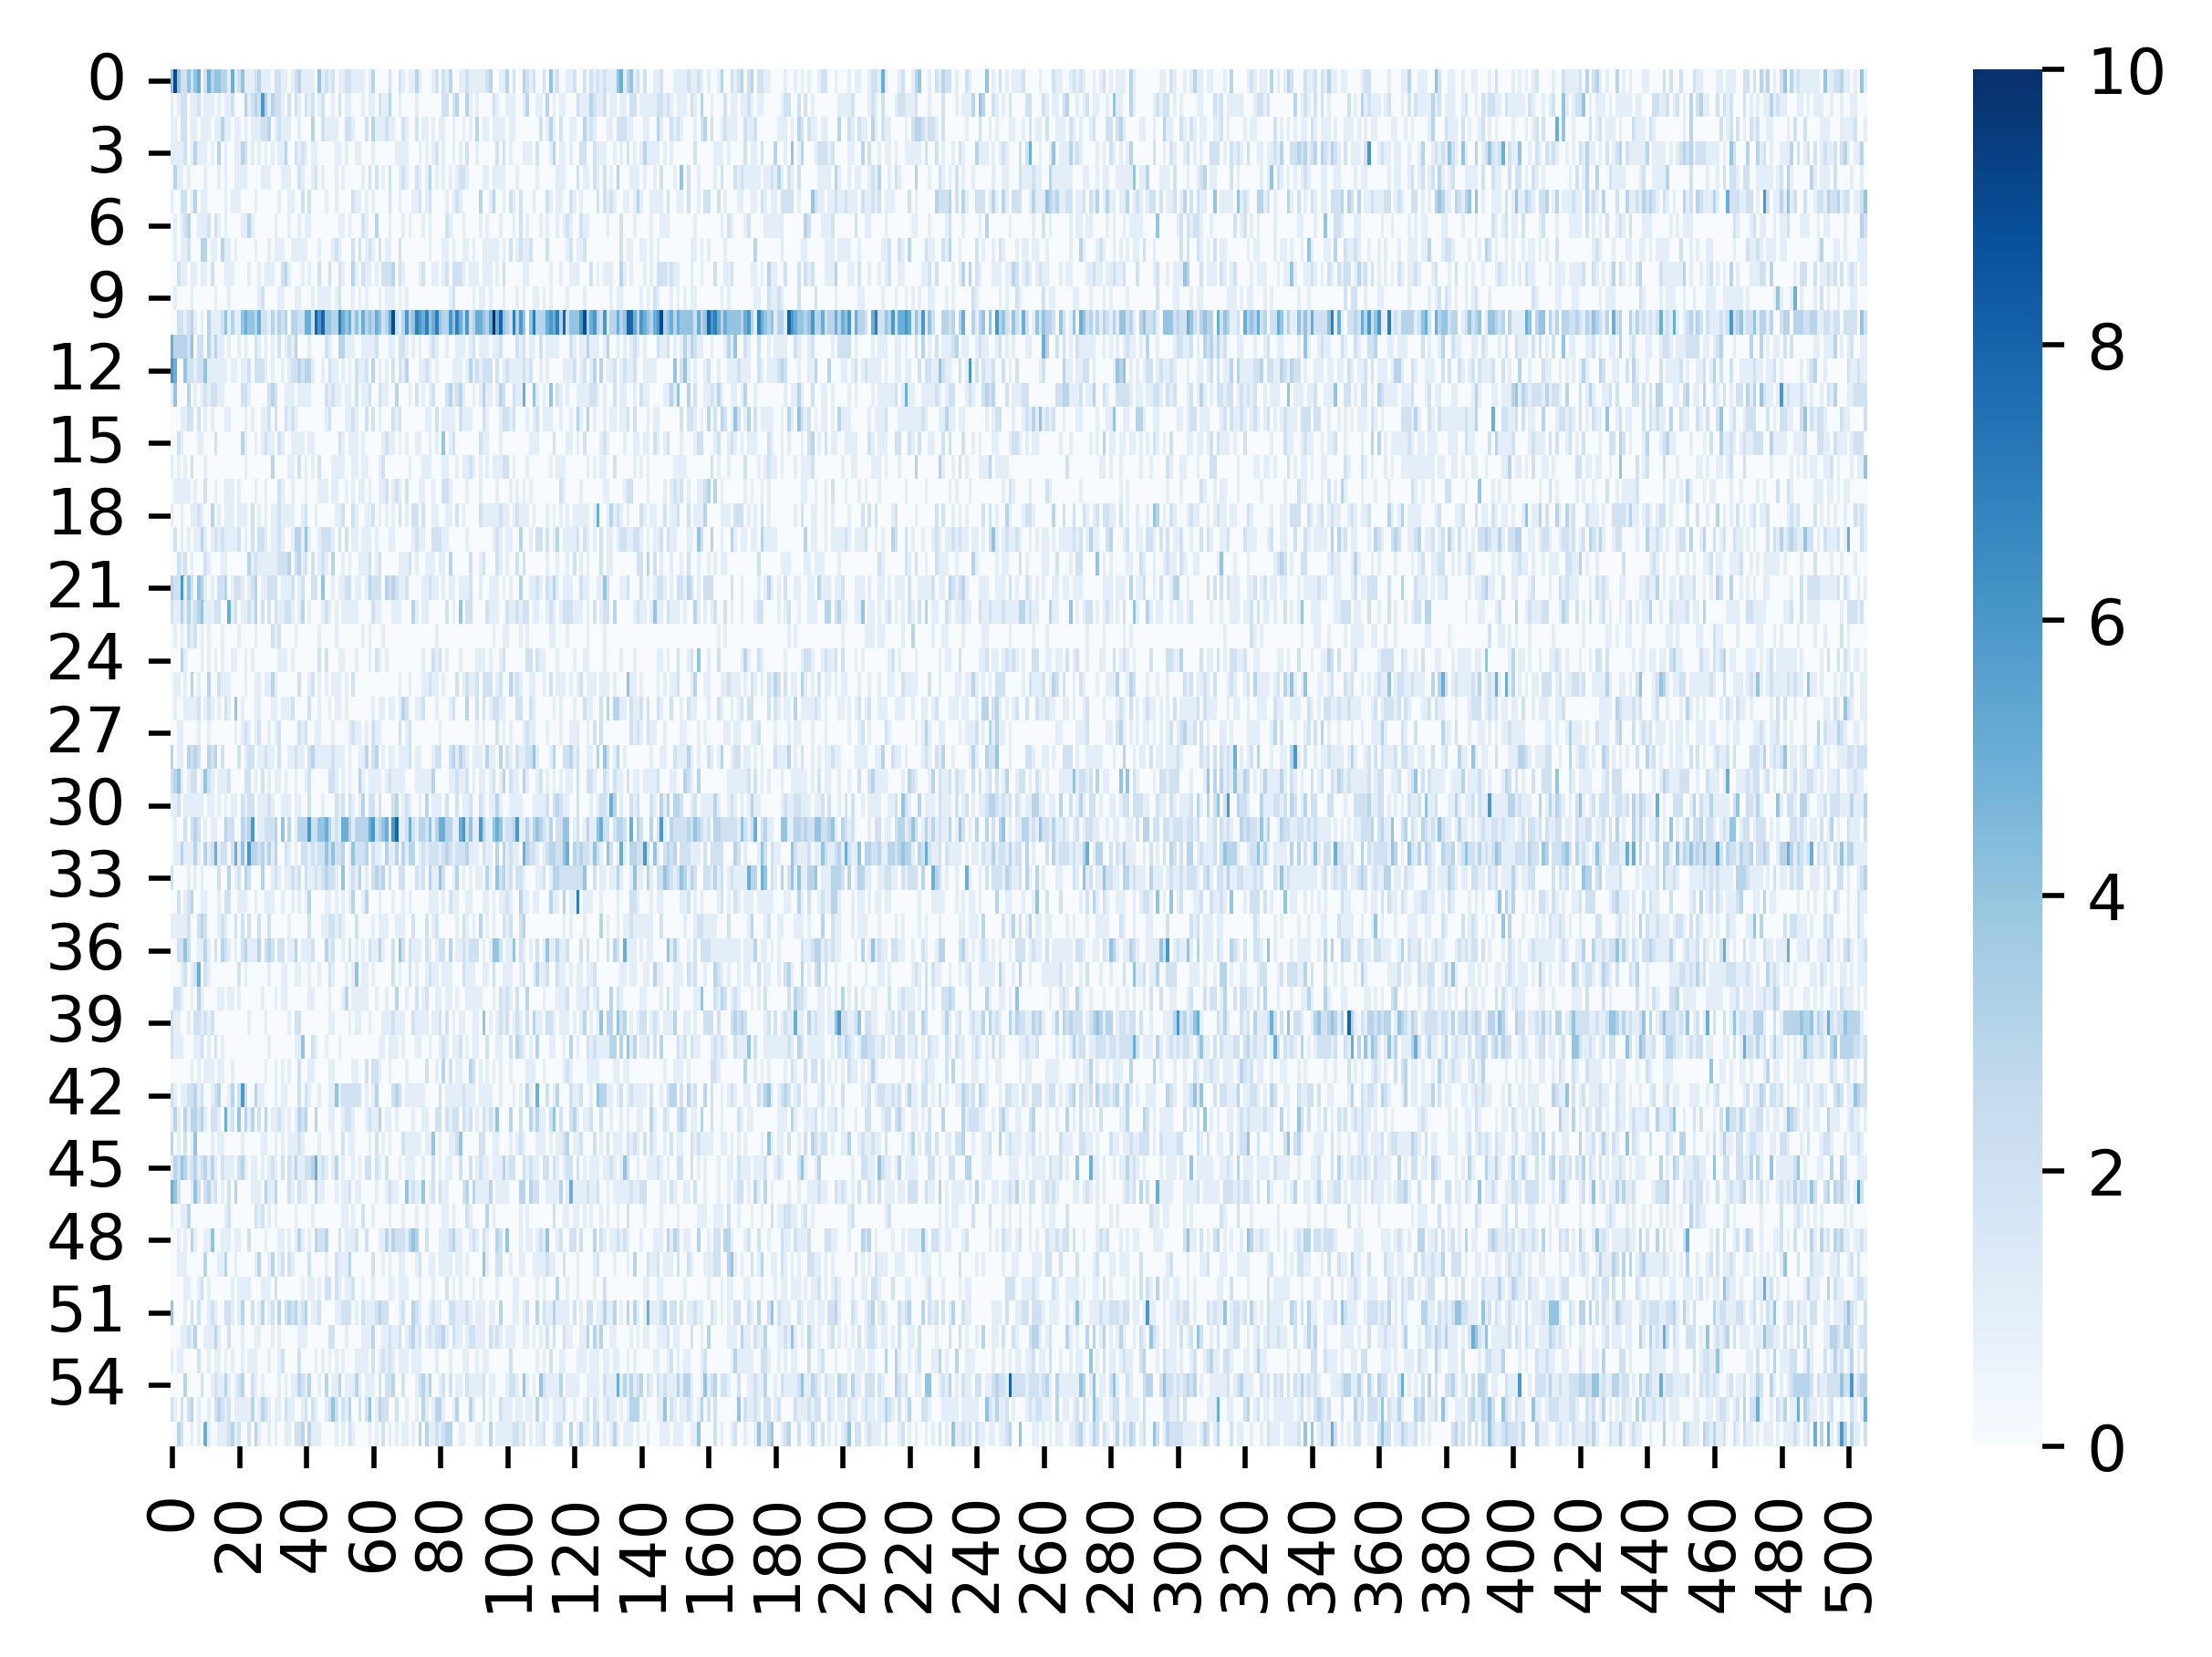

In [13]:
sns.heatmap(neg_counts, cmap='Blues')

<AxesSubplot:>

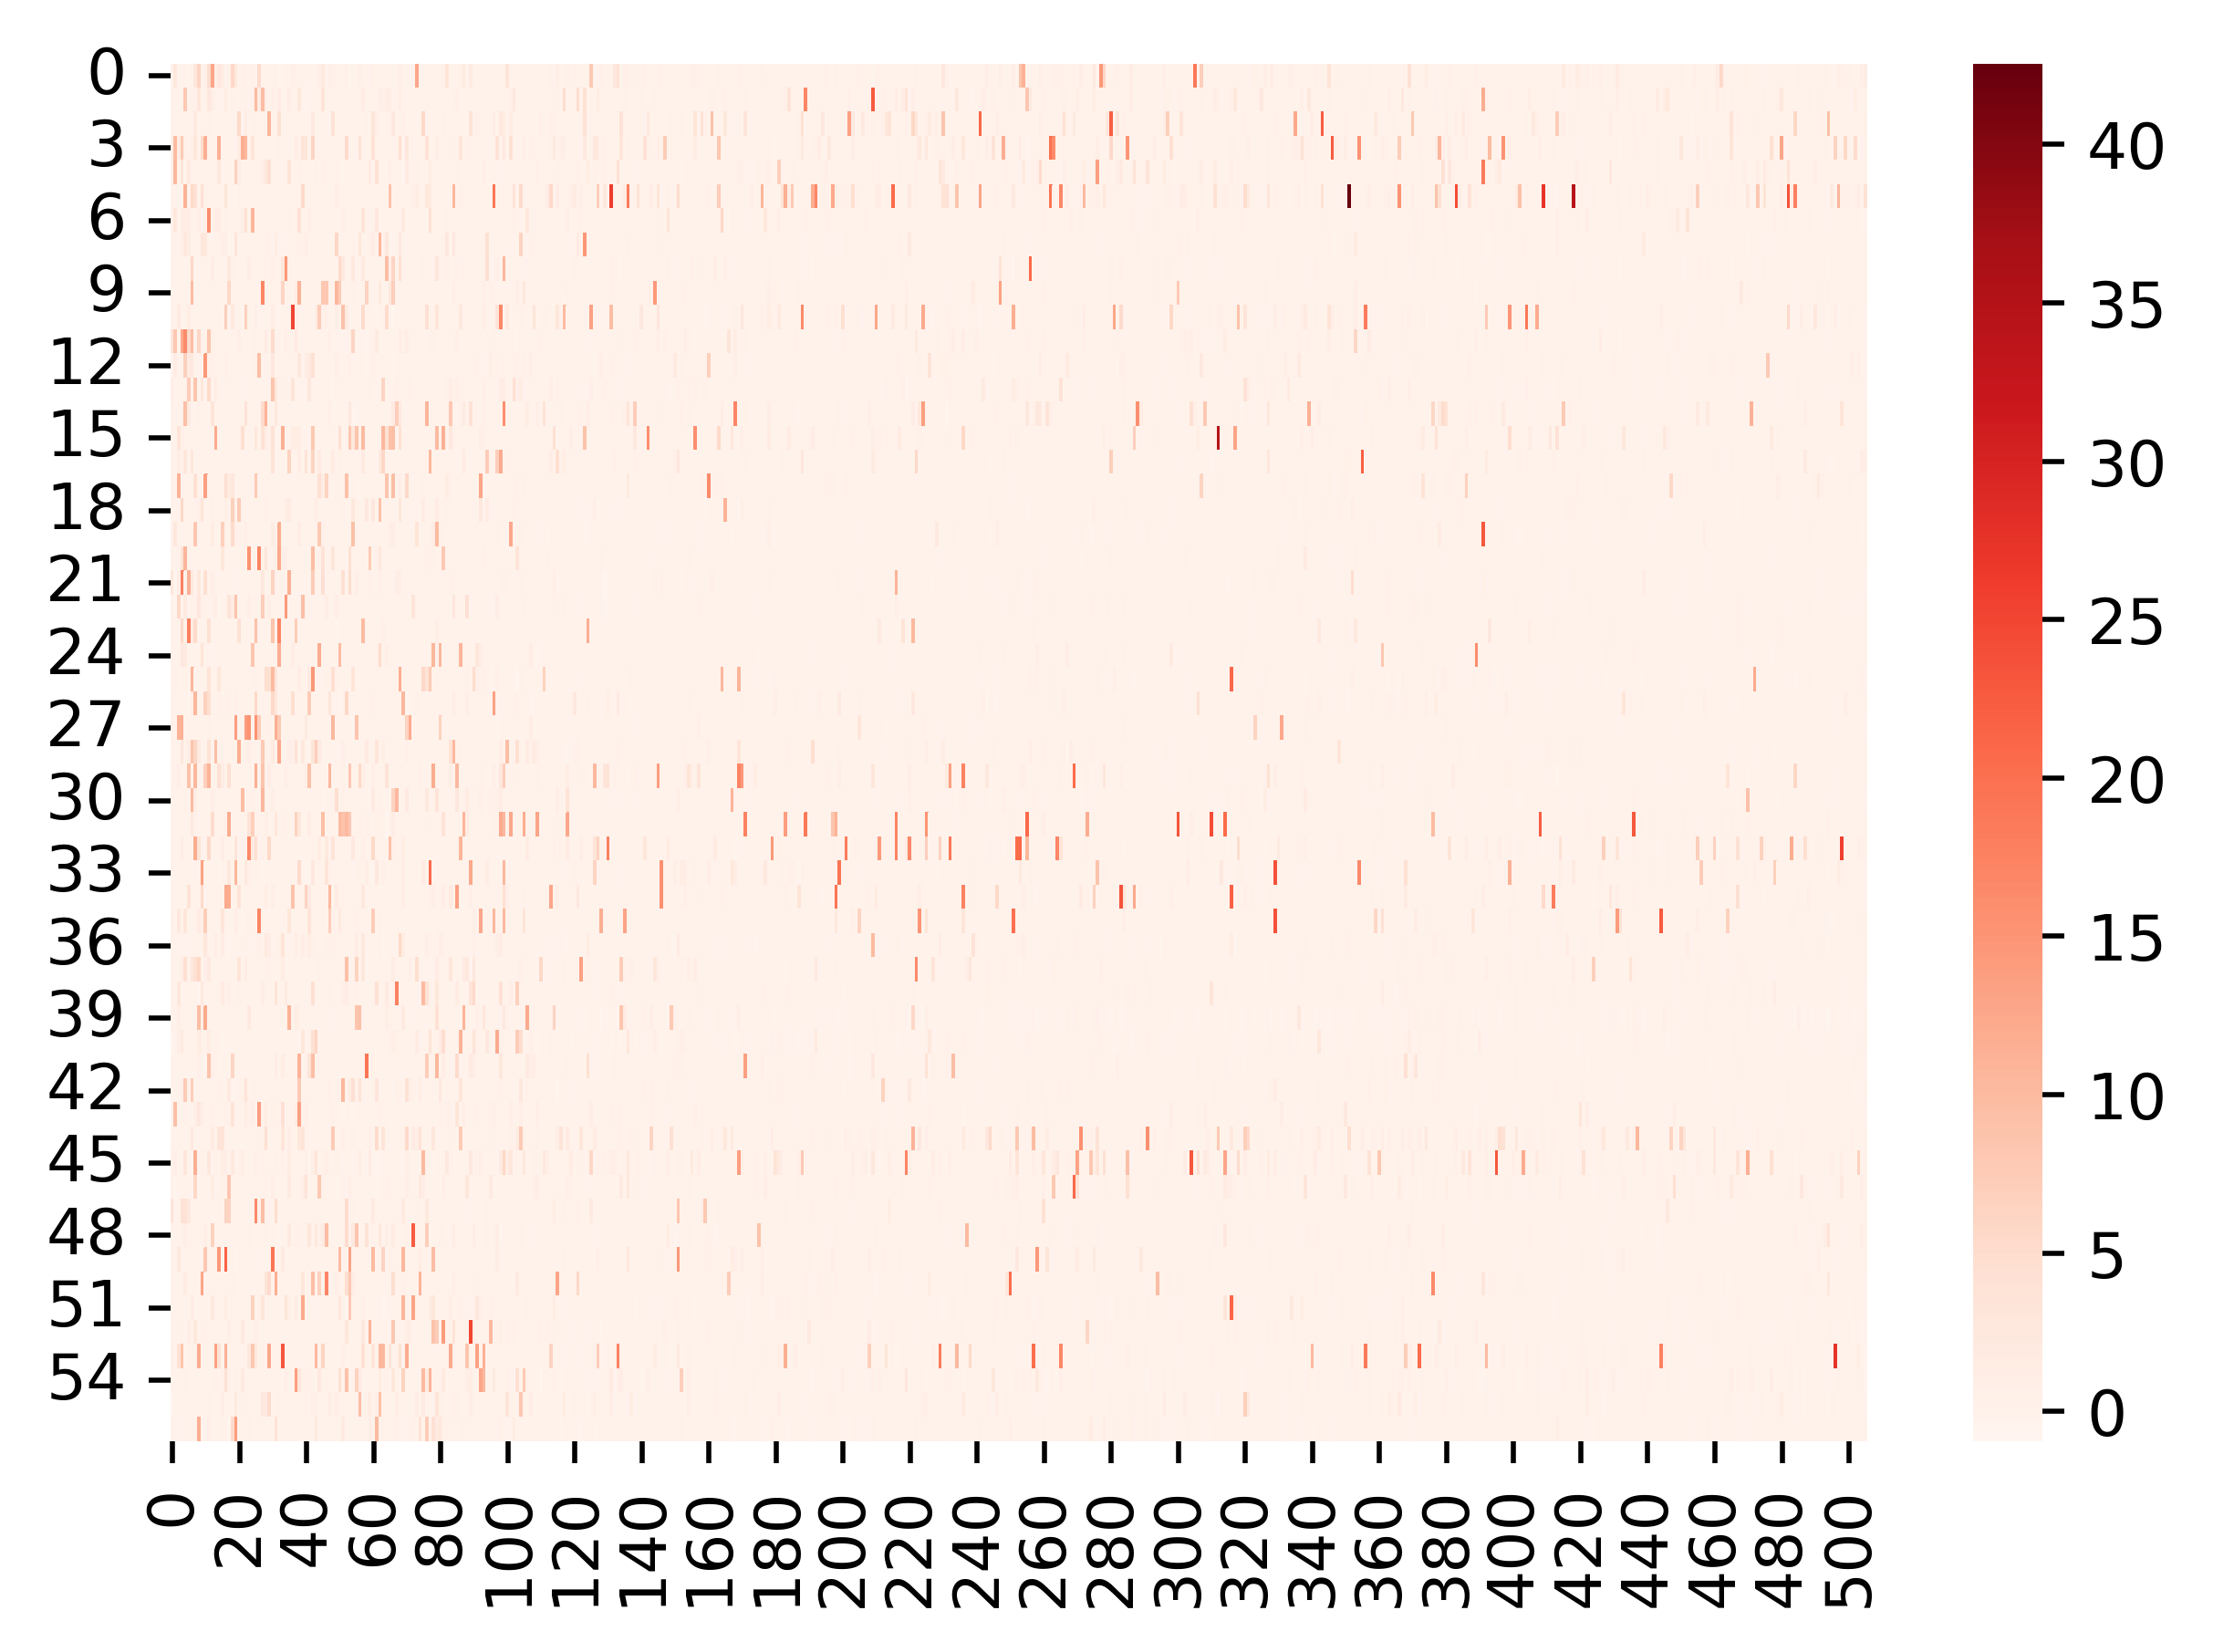

In [14]:
sns.heatmap(neg_importance, cmap='Reds')